<a href="https://colab.research.google.com/github/ChiaraSolito/ComputerVisionProject/blob/main/YOLOv5_training_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diving deeper into YOLO v5
Since, in contrast to Faster RCNN, YOLO gives us a training script, we tried to understand which parts of the code we were using, why and how. To do so, we tried to write our own writing script, simulating the one from Ultralytics.

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
!pip install --upgrade ultralytics
!pip install pathlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install pycocotools

In [ ]:
import os
import io
import cv2
import time
import copy
import torch
import contextlib
import torchvision
import torch.utils.data
import yaml

import numpy as np
import torchvision.transforms as T
import pathlib

from PIL import Image
# from tqdm import tqdm
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as coco_mask
from torch import hub
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# Seed.
np.random.seed(66)
torch.manual_seed(66)

# Hyperparameters.
EPOCH = 25
BATCH_SIZE = 8
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading the model
We load the model directly from torch hub: to load it for training rather than inference, we set autoshape=False, to also train from scratch we use pretrained=False.

In [ ]:
model = hub.load('ultralytics/yolov5', 'yolov5m',autoshape=False, pretrained=False, classes=1, force_reload=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 17.0 MB/s eta

### Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Tiny_PlasticBottles')

In [ ]:
from utils import dataloaders

 ## Defining parameters

In [ ]:
# Move model to the right device.
model.to(DEVICE)

# Define the optimizer and a learning rate scheduler.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0005
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                               gamma=0.1)

In [ ]:
with open("/content/drive/MyDrive/Tiny_PlasticBottles/data.yaml") as f:
  data_dict = yaml.safe_load(f)  # data dict

## Some utils
The most important function here is the calculation of the IoU for bounding boxes

In [ ]:
import math
from torch import nn

def make_divisible(x, divisor):
    # Returns x evenly divisible by divisor
    return math.ceil(x / divisor) * divisor

def check_img_size(img_size, s=32):
    # Verify img_size is a multiple of stride s
    new_size = make_divisible(img_size, int(s))  # ceil gs-multiple
    if new_size != img_size:
        print('WARNING: --img-size %g must be multiple of max stride %g, updating to %g' % (img_size, s, new_size))
    return new_size

def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, (b1_y2 - b1_y1).clamp(eps)
        w2, h2 = b2_x2 - b2_x1, (b2_y2 - b2_y1).clamp(eps)

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU

def is_parallel(model):
    # Returns True if model is of type DP or DDP
    return type(model) in (nn.parallel.DataParallel, nn.parallel.DistributedDataParallel)

def de_parallel(model):
    # De-parallelize a model: returns single-GPU model if model is of type DP or DDP
    return model.module if is_parallel(model) else model

def fitness(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)

def labels_to_class_weights(labels, nc=80):
    # Get class weights (inverse frequency) from training labels
    if labels[0] is None:  # no labels loaded
        return torch.Tensor()

    labels = np.concatenate(labels, 0)  # labels.shape = (866643, 5) for COCO
    classes = labels[:, 0].astype(int)  # labels = [class xywh]
    weights = np.bincount(classes, minlength=nc)  # occurrences per class
    # Prepend gridpoint count (for uCE training)
    # gpi = ((320 / 32 * np.array([1, 2, 4])) ** 2 * 3).sum()  # gridpoints per image
    # weights = np.hstack([gpi * len(labels)  - weights.sum() * 9, weights * 9]) ** 0.5  # prepend gridpoints to start

    weights[weights == 0] = 1  # replace empty bins with 1
    weights = 1 / weights  # number of targets per class
    weights /= weights.sum()  # normalize
    return torch.from_numpy(weights).float()


## YOLOv5 loss functions
We take this directly from YOLO repository by Ultralytics

In [ ]:
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Loss functions
"""

import torch
import torch.nn as nn
import yaml

def smooth_BCE(eps=0.1):  # https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441
    # return positive, negative label smoothing BCE targets
    return 1.0 - 0.5 * eps, 0.5 * eps


class BCEBlurWithLogitsLoss(nn.Module):
    # BCEwithLogitLoss() with reduced missing label effects.
    def __init__(self, alpha=0.05):
        super().__init__()
        self.loss_fcn = nn.BCEWithLogitsLoss(reduction='none')  # must be nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)
        pred = torch.sigmoid(pred)  # prob from logits
        dx = pred - true  # reduce only missing label effects
        # dx = (pred - true).abs()  # reduce missing label and false label effects
        alpha_factor = 1 - torch.exp((dx - 1) / (self.alpha + 1e-4))
        loss *= alpha_factor
        return loss.mean()


class FocalLoss(nn.Module):
    # Wraps focal loss around existing loss_fcn(), i.e. criteria = FocalLoss(nn.BCEWithLogitsLoss(), gamma=1.5)
    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = 'none'  # required to apply FL to each element

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = torch.sigmoid(pred)  # prob from logits
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss


class QFocalLoss(nn.Module):
    # Wraps Quality focal loss around existing loss_fcn(), i.e. criteria = FocalLoss(nn.BCEWithLogitsLoss(), gamma=1.5)
    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = 'none'  # required to apply FL to each element

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)

        pred_prob = torch.sigmoid(pred)  # prob from logits
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss


class ComputeLoss:
    sort_obj_iou = False

    # Compute losses
    def __init__(self, model, autobalance=False):
        device = next(model.parameters()).device  # get model device
        with open("/content/drive/MyDrive/hyp.scratch-low.yaml") as f:
          h=yaml.safe_load(f)

        # Define criteria
        BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h['cls_pw']], device=device))
        BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h['obj_pw']], device=device))

        # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
        self.cp, self.cn = smooth_BCE(eps=h.get('label_smoothing', 0.0))  # positive, negative BCE targets

        # Focal loss
        g = h['fl_gamma']  # focal loss gamma
        if g > 0:
            BCEcls, BCEobj = FocalLoss(BCEcls, g), FocalLoss(BCEobj, g)

        m = de_parallel(model).model[-1]  # Detect() module
        self.balance = {3: [4.0, 1.0, 0.4]}.get(m.nl, [4.0, 1.0, 0.25, 0.06, 0.02])  # P3-P7
        self.ssi = list(m.stride).index(16) if autobalance else 0  # stride 16 index
        self.BCEcls, self.BCEobj, self.gr, h, self.autobalance = BCEcls, BCEobj, 1.0, h, autobalance
        self.na = m.na  # number of anchors
        self.nc = m.nc  # number of classes
        self.nl = m.nl  # number of layers
        self.anchors = m.anchors
        self.device = device

    def __call__(self, p, targets):  # predictions, targets

        with open("/content/drive/MyDrive/hyp.scratch-low.yaml") as f:
          h=yaml.safe_load(f)

        lcls = torch.zeros(1, device=self.device)  # class loss
        lbox = torch.zeros(1, device=self.device)  # box loss
        lobj = torch.zeros(1, device=self.device)  # object loss
        tcls, tbox, indices, anchors = self.build_targets(p, targets)  # targets

        # Losses
        for i, pi in enumerate(p):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
            tobj = torch.zeros(pi.shape[:4], dtype=pi.dtype, device=self.device)  # target obj

            n = b.shape[0]  # number of targets
            if n:
                # pxy, pwnh, _, pcls = pi[b, a, gj, gi].tensor_split((2, 4, 5), dim=1)  # faster, requires torch 1.8.0
                pxy, pwh, _, pcls = pi[b, a, gj, gi].split((2, 2, 1, self.nc), 1)  # target-subset of predictions

                # Regression
                pxy = pxy.sigmoid() * 2 - 0.5
                pwh = (pwh.sigmoid() * 2) ** 2 * anchors[i]
                pbox = torch.cat((pxy, pwh), 1)  # predicted box
                iou = bbox_iou(pbox, tbox[i], CIoU=True).squeeze()  # iou(prediction, target)
                lbox += (1.0 - iou).mean()  # iou loss

                # Objectness
                iou = iou.detach().clamp(0).type(tobj.dtype)
                if self.sort_obj_iou:
                    j = iou.argsort()
                    b, a, gj, gi, iou = b[j], a[j], gj[j], gi[j], iou[j]
                if self.gr < 1:
                    iou = (1.0 - self.gr) + self.gr * iou
                tobj[b, a, gj, gi] = iou  # iou ratio

                # Classification
                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = torch.full_like(pcls, self.cn, device=self.device)  # targets
                    t[range(n), tcls[i]] = self.cp
                    lcls += self.BCEcls(pcls, t)  # BCE

                # Append targets to text file
                # with open('targets.txt', 'a') as file:
                #     [file.write('%11.5g ' * 4 % tuple(x) + '\n') for x in torch.cat((txy[i], twh[i]), 1)]

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]  # obj loss
            if self.autobalance:
                self.balance[i] = self.balance[i] * 0.9999 + 0.0001 / obji.detach().item()

        if self.autobalance:
            self.balance = [x / self.balance[self.ssi] for x in self.balance]
        lbox *= h['box']
        lobj *= h['obj']
        lcls *= h['cls']
        bs = tobj.shape[0]  # batch size

        return (lbox + lobj + lcls) * bs, torch.cat((lbox, lobj, lcls)).detach()

    def build_targets(self, p, targets):
        with open("/content/drive/MyDrive/hyp.scratch-low.yaml") as f:
          h=yaml.safe_load(f)
        # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
        na, nt = self.na, targets.shape[0]  # number of anchors, targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=self.device)  # normalized to gridspace gain
        ai = torch.arange(na, device=self.device).float().view(na, 1).repeat(1, nt)  # same as .repeat_interleave(nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[..., None]), 2)  # append anchor indices

        g = 0.5  # bias
        off = torch.tensor(
            [
                [0, 0],
                [1, 0],
                [0, 1],
                [-1, 0],
                [0, -1],  # j,k,l,m
                # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
            ],
            device=self.device).float() * g  # offsets

        for i in range(self.nl):
            anchors, shape = self.anchors[i], p[i].shape
            gain[2:6] = torch.tensor(shape)[[3, 2, 3, 2]]  # xyxy gain

            # Match targets to anchors
            t = targets * gain  # shape(3,n,7)
            if nt:
                # Matches
                r = t[..., 4:6] / anchors[:, None]  # wh ratio
                j = torch.max(r, 1 / r).max(2)[0] < h['anchor_t']  # compare
                # j = wh_iou(anchors, t[:, 4:6]) > h['iou_t']  # iou(3,n)=wh_iou(anchors(3,2), gwh(n,2))
                t = t[j]  # filter

                # Offsets
                gxy = t[:, 2:4]  # grid xy
                gxi = gain[[2, 3]] - gxy  # inverse
                j, k = ((gxy % 1 < g) & (gxy > 1)).T
                l, m = ((gxi % 1 < g) & (gxi > 1)).T
                j = torch.stack((torch.ones_like(j), j, k, l, m))
                t = t.repeat((5, 1, 1))[j]
                offsets = (torch.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                t = targets[0]
                offsets = 0

            # Define
            bc, gxy, gwh, a = t.chunk(4, 1)  # (image, class), grid xy, grid wh, anchors
            a, (b, c) = a.long().view(-1), bc.long().T  # anchors, image, class
            gij = (gxy - offsets).long()
            gi, gj = gij.T  # grid indices

            # Append
            indices.append((b, a, gj.clamp_(0, shape[2] - 1), gi.clamp_(0, shape[3] - 1)))  # image, anchor, grid
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
            anch.append(anchors[a])  # anchors
            tcls.append(c)  # class

        return tcls, tbox, indices, anch

In [ ]:
epochs = 25
device = DEVICE
with open("/content/drive/MyDrive/hyp.scratch-low.yaml") as f:
  hyp=yaml.safe_load(f)
batch_size = BATCH_SIZE

# Resume
start_epoch, best_fitness = 0, 0.0
cuda = device.type != 'cpu'

# Directories
save_dir = "/content/drive/MyDrive/Tiny_PlasticBottles/results"
wdir = save_dir + '/weights'
if not os.path.exists(wdir):
  os.mkdir(wdir)  # make dir
last = wdir + '/last.pt'
best = wdir + '/best.pt'
results_file = save_dir + '/results.txt'

# Image sizes
gs = max(int(model.stride.max()), 32)  # grid size (max stride)gs
nl = model.model[-1].nl  # number of detection layers (used for scaling hyp['obj'])
imgsz, imgsz_test = [check_img_size(x, gs) for x in [28, 28]]  # verify imgsz are gs-multiples


train_loader, dataset = dataloaders.create_dataloader("/content/drive/MyDrive/Tiny_PlasticBottles/train",
                                          imgsz,
                                          batch_size,
                                          gs,
                                          True,
                                          hyp=hyp,
                                          augment=True,
                                          shuffle=True)

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


Scanning /content/drive/MyDrive/Tiny_PlasticBottles/train/labels.cache... 296 images, 2 backgrounds, 0 corrupt: 100%|██████████| 296/296 [00:00<?, ?it/s]


# TRAINING SCRIPT
The training script was written ex novo, taking as an example the one from Ultralytics.

In [ ]:
from torch.cuda import amp
import test
import os
import random
from threading import Thread
from copy import deepcopy
from datetime import datetime

RANK = int(os.getenv('RANK', -1))
# Trainloader
labels = np.concatenate(dataset.labels, 0)
nb = len(train_loader)  # number of batches
 # Start training
t0 = time.time()
nbs = 64  # nominal batch size
nw = max(round(hyp['warmup_epochs'] * nb), 1000)  # number of warmup iterations, max(3 epochs, 1k iterations)
nc = 1
maps = np.zeros(nc)  # mAP per class
results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
scheduler.last_epoch = start_epoch - 1  # do not move
scaler = amp.GradScaler(enabled=cuda)
compute_loss = ComputeLoss(model)  # init loss class
lf = lambda x: (1 - x / (epochs - 1)) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear

# Model attributes
hyp['box'] *= 3 / nl  # scale to layers
hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
hyp['obj'] *= (imgsz / 28) ** 2 * 3 / nl  # scale to image size and layers
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
model.names = {0: 'item'}

for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        mloss = torch.zeros(3, device=device)  # mean losses
        if RANK != -1:
            train_loader.sampler.set_epoch(epoch)
        pbar = enumerate(train_loader)
        print(('\n' + '%11s' * 7) % ('Epoch', 'GPU_mem', 'box_loss', 'obj_loss', 'cls_loss', 'Instances', 'Size'))


        if RANK in [-1, 0]:
            pbar = tqdm(pbar, total=nb)  # progress bar
        optimizer.zero_grad()

        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])


            # Forward
            preds = []
            with amp.autocast(enabled=cuda):
              #print(imgs.shape)
              pred = model(imgs)  # forward
              loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size

            # Backward
            scaler.scale(loss).backward()

            # Optimize
            if ni % accumulate == 0:
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()

            # Print
            if RANK in [-1, 0]:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
                pbar.set_description(('%11s' * 2 + '%11.4g' * 5) %
                                     (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
            # end batch ------------------------------------------------------------------------------------------------
        print(('%11s' * 2 + '%11.4g' * 5) % (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        if RANK in [-1, 0]:
                final_epoch = epoch + 1 == epochs

                # Write
                with open(results_file, 'a') as f:
                    f.write(('%11s' * 2 + '%11.4g' * 5) % (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))  # append metrics, val_loss

                # Update best mAP
                fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
                if fi > best_fitness and final_epoch:
                      best_fitness = fi

                # Save model
                ckpt = {
                    'epoch': epoch,
                    'best_fitness': best_fitness,
                    'model': deepcopy(de_parallel(model)).half(),
                    'optimizer': optimizer.state_dict(),
                    'date': datetime.now().isoformat()}

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                del ckpt

      # end epoch ----------------------------------------------------------------------------------------------------
  # end training -----------------------------------------------------------------------------------------------------

torch.cuda.empty_cache()


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       0/24     0.677G    0.06829     0.7539          0         21         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       1/24     0.677G    0.06552     0.6973          0          8         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       2/24     0.677G    0.06785     0.7333          0         20         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       3/24     0.677G     0.0674     0.7474          0         29         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       4/24     0.677G    0.06728     0.6648          0         25         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       5/24     0.677G     0.0714     0.7718          0         12         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       6/24     0.677G    0.06782     0.7468          0         21         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       7/24     0.677G    0.06442     0.7442          0         21         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       8/24     0.677G    0.06586     0.7298          0         22         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

       9/24     0.677G    0.06833     0.7343          0         15         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      10/24     0.677G    0.06455     0.7155          0         30         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      11/24     0.677G    0.06538      0.692          0         13         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      12/24     0.677G    0.07098     0.7114          0         24         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      13/24     0.677G    0.06539     0.7252          0         18         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      14/24     0.677G     0.0657     0.6957          0         10         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      15/24     0.677G    0.07016     0.8041          0         11         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      16/24     0.677G    0.06782     0.7029          0         18         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      17/24     0.677G    0.06541      0.726          0         13         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      18/24     0.677G    0.06738     0.7254          0         26         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      19/24     0.677G    0.06812     0.6977          0         16         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      20/24     0.677G    0.07099     0.7776          0         14         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      21/24     0.677G    0.05831     0.7184          0         15         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      22/24     0.677G    0.06469     0.7523          0         20         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      23/24     0.677G    0.06779     0.7391          0         15         32

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]

      24/24     0.677G    0.06674     0.7814          0         14         32


## Validation and Testing
We validate and test using the original script, to have results and metrics comparable to the ones we produced in the previous experiments.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 2023-9-16 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


In [ ]:
!python val.py --weights '/content/drive/MyDrive/Tiny_PlasticBottles/results/weights/best.pt'  --data "/content/drive/MyDrive/Tiny_PlasticBottles/data.yaml" --img 28

val: data=/content/drive/MyDrive/Tiny_PlasticBottles/data.yaml, weights=['/content/drive/MyDrive/Tiny_PlasticBottles/results/weights/best.pt'], batch_size=32, imgsz=28, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-218-g9e97ac3 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 24246 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size 28 must be multiple of max stride 32, updating to 32
val: Scanning /content/drive/MyDrive/Tiny_PlasticBottles/valid/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100% 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:20<00:00, 20.05s/it]
                   all         26         3

In [ ]:
!python detect.py --weights '/content/drive/MyDrive/Tiny_PlasticBottles/results/weights/best.pt' --source "/content/drive/MyDrive/Tiny_PlasticBottles/test/images"

detect: weights=['/content/drive/MyDrive/Tiny_PlasticBottles/results/weights/best.pt'], source=/content/drive/MyDrive/Tiny_PlasticBottles/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-218-g9e97ac3 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 24246 gradients, 47.9 GFLOPs
image 1/13 /content/drive/MyDrive/Tiny_PlasticBottles/test/images/000002_jpg.rf.a8b00452ca2b72a30b904f2ee7aecc9f.jpg: 640x640 143 items, 41.6ms
image 2/13 /content/drive/MyDrive/Tiny_PlasticBottles/test/images/PET1-005_jpg.rf.990297e6c745e019b2449fa8f2

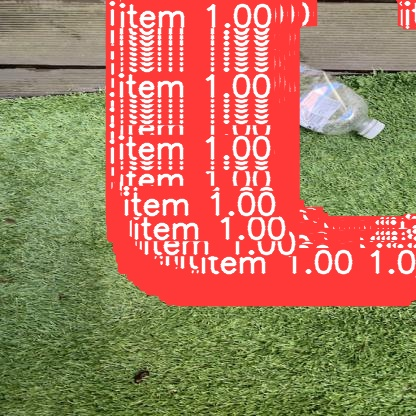

In [ ]:
display.Image(filename="/content/yolov5/runs/detect/exp/PET1-142_jpg.rf.5bb99672cda80427c6ef40b056c8e0ff.jpg", width=360)